In [649]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import datetime, timedelta
from sklearn.linear_model import Ridge
from joblib import dump, load


In [650]:
# Function to fetch metadata and determine start date
def get_start_date(symbol, token, max_years=15):
    headers = {'Content-Type': 'application/json'}
    meta_url = f'https://api.tiingo.com/tiingo/daily/{symbol}?token={token}'
    meta_response = requests.get(meta_url, headers=headers)
    meta_data = meta_response.json()
    
    # Extract the start date from metadata
    start_date = datetime.strptime(meta_data['startDate'], '%Y-%m-%d')
    
    # Calculate date 15 years ago from today
    years_ago_date = datetime.now() - timedelta(days=max_years * 365)
    
    # Use the later of the two dates as the start date for fetching historical data
    optimal_start_date = max(start_date, years_ago_date).strftime('%Y-%m-%d')
    return optimal_start_date

# Your existing function for fetching data, updated to use the dynamic start date
def fetch_data(symbol, token):
    start_date = get_start_date(symbol, token)
    headers = {'Content-Type': 'application/json'}
    url = f'https://api.tiingo.com/tiingo/daily/{symbol}/prices?startDate={start_date}&token={token}'
    response = requests.get(url, headers=headers)
    return pd.DataFrame(response.json())

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['adjClose'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [651]:
# Token and stock symbol input
token = "3ab68f4b54224a51847d25a4dc930dfa87b55e2a"
stock_symbol = input("Enter Stock Symbol").lower()

In [652]:
# Fetch data using the new dynamic start date logic
stock_data = fetch_data(stock_symbol, token)
index_data = fetch_data('spy', token)  # SPY as an example for the index
vxx_data = fetch_data('vxx', token)  # VXX data

In [653]:
stock_data

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2009-03-30T00:00:00.000Z,104.49,105.01,102.61,104.510,17957000,3.159042,3.174763,3.102204,3.159647,502796502,0.0,1.0
1,2009-03-31T00:00:00.000Z,105.12,107.45,105.00,105.450,20360000,3.178089,3.248532,3.174461,3.188066,570080570,0.0,1.0
2,2009-04-01T00:00:00.000Z,108.69,109.00,103.89,104.090,21049000,3.286021,3.295393,3.140902,3.146949,589372589,0.0,1.0
3,2009-04-02T00:00:00.000Z,112.71,114.75,109.78,110.145,29013100,3.407557,3.469232,3.318974,3.330009,812367612,0.0,1.0
4,2009-04-03T00:00:00.000Z,115.99,116.13,113.52,114.190,22722900,3.506721,3.510954,3.432046,3.452302,636241836,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,2024-03-20T00:00:00.000Z,178.67,178.67,175.09,175.720,53423102,178.670000,178.670000,175.090000,175.720000,53423102,0.0,1.0
3770,2024-03-21T00:00:00.000Z,171.37,177.49,170.84,177.050,106181270,171.370000,177.490000,170.840000,177.050000,106181270,0.0,1.0
3771,2024-03-22T00:00:00.000Z,172.28,173.05,170.06,171.760,71160138,172.280000,173.050000,170.060000,171.760000,71160138,0.0,1.0
3772,2024-03-25T00:00:00.000Z,170.85,171.94,169.45,170.565,54288328,170.850000,171.940000,169.450000,170.565000,54288328,0.0,1.0


In [654]:
# Preprocessing data
stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')
stock_data['date'] = stock_data['date'].dt.date
stock_data.drop(['divCash', 'splitFactor'], axis=1, inplace=True)
stock_data['RSI'] = calculate_rsi(stock_data).fillna(50)

index_data['date'] = pd.to_datetime(index_data['date'], errors='coerce')
index_data['date'] = index_data['date'].dt.date
index_data.drop(['divCash', 'splitFactor'], axis=1, inplace=True)

vxx_data['date'] = pd.to_datetime(vxx_data['date'], errors='coerce')
vxx_data['date'] = vxx_data['date'].dt.date
vxx_data.drop(['divCash', 'splitFactor'], axis=1, inplace=True)

In [655]:
stock_data['price_ratio_to_index'] = stock_data['adjClose'] / index_data['adjClose']
stock_data['price_ratio_to_vxx'] = stock_data['adjClose'] / vxx_data['adjClose']


In [656]:
stock_data['price_diff_from_index'] = stock_data['adjClose'] - index_data['adjClose']
stock_data['price_diff_from_vxx'] = stock_data['adjClose'] - vxx_data['adjClose']


In [657]:
stock_data['log_returns'] = np.log(stock_data['adjClose'] / stock_data['adjClose'].shift(1))
stock_data['volatility_adjusted_returns'] = stock_data['log_returns'] / vxx_data['adjClose']


In [658]:
for window in [14, 30, 90]:
    stock_data[f'ma_{window}'] = stock_data['adjClose'].rolling(window=window).mean()
    stock_data[f'index_ma_{window}'] = index_data['adjClose'].rolling(window=window).mean()
    stock_data[f'stock_over_ma_{window}'] = stock_data['adjClose'] / stock_data[f'ma_{window}']
    stock_data[f'index_over_ma_{window}'] = index_data['adjClose'] / stock_data[f'index_ma_{window}']


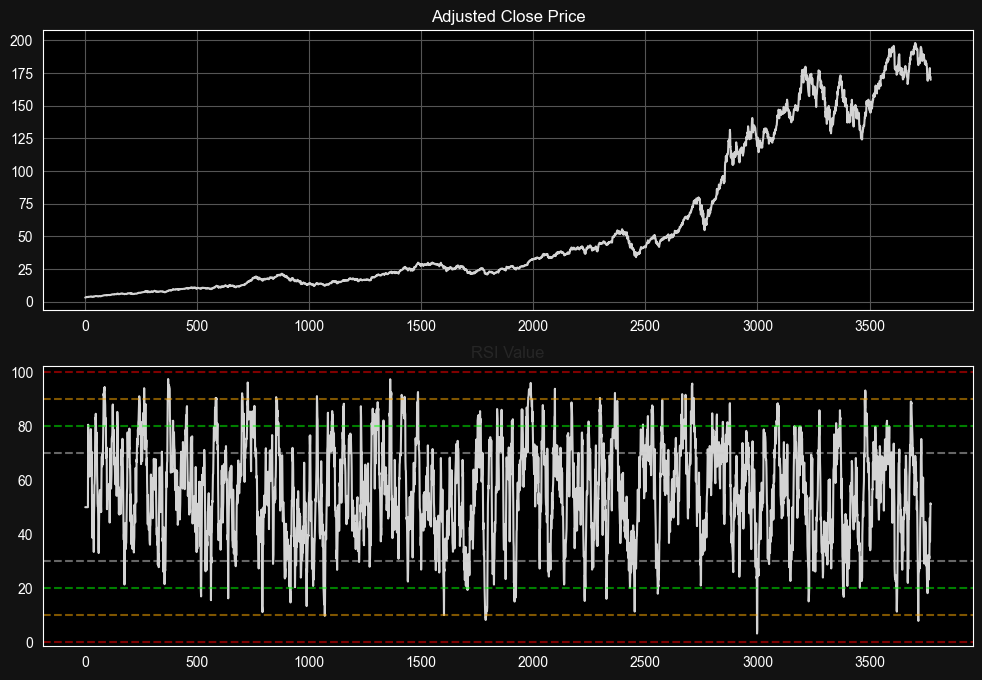

In [659]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
ax1.plot(stock_data.index, stock_data['adjClose'], color='lightgray')
ax1.set_title('Adjusted Close Price', color='white')

ax1.grid(True, color='#555555')
ax1.set_axisbelow(True)
ax1.set_facecolor('black')
ax1.figure.set_facecolor('#121212')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(stock_data.index, stock_data['RSI'], color='lightgray')
ax2.axhline(0, linestyle='--',alpha=0.5, color='#ff0000')
ax2.axhline(10, linestyle='--',alpha=0.5, color='#ffaa00')
ax2.axhline(20, linestyle='--',alpha=0.5, color='#00ff00')
ax2.axhline(30, linestyle='--',alpha=0.5, color='#cccccc')
ax2.axhline(70, linestyle='--',alpha=0.5, color='#cccccc')
ax2.axhline(80, linestyle='--',alpha=0.5, color='#00ff00')
ax2.axhline(90, linestyle='--',alpha=0.5, color='#ffaa00')
ax2.axhline(100, linestyle='--',alpha=0.5, color='#ff0000')

ax2.set_title('RSI Value')
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_facecolor('black')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

In [660]:
# Creating lag features for the 'adjClose' column
stock_data['lag_1_day'] = stock_data['adjClose'].shift(1)   # 1-day lag
stock_data['lag_5_days'] = stock_data['adjClose'].shift(5)  # 5-day lag
stock_data['lag_30_days'] = stock_data['adjClose'].shift(30) # 30-day lag
stock_data['lag_45_days'] = stock_data['adjClose'].shift(45) # 45-day lag

In [661]:
stock_data = stock_data.dropna()

In [662]:
stock_data

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,...,stock_over_ma_30,index_over_ma_30,ma_90,index_ma_90,stock_over_ma_90,index_over_ma_90,lag_1_day,lag_5_days,lag_30_days,lag_45_days
89,2009-08-05,165.11,167.39,164.21,165.750,15113700,4.991764,5.060695,4.964554,5.011113,...,1.104413,1.068601,4.079682,68.445516,1.223567,1.112124,5.005067,4.838181,4.051519,4.217196
90,2009-08-06,163.91,166.51,163.09,165.580,12200600,4.955485,5.034090,4.930694,5.005974,...,1.089659,1.059395,4.099642,68.626961,1.208760,1.103439,4.991764,4.921624,4.118334,4.261336
91,2009-08-07,165.51,166.60,164.80,165.490,13834100,5.003857,5.036811,4.982392,5.003253,...,1.094077,1.069839,4.119929,68.813327,1.214550,1.114882,4.955485,4.939763,4.228382,4.345686
92,2009-08-10,164.72,166.60,163.66,165.660,10724800,4.979973,5.036811,4.947926,5.008392,...,1.083536,1.064188,4.138750,68.985024,1.203255,1.109800,5.003857,5.031672,4.306383,4.373802
93,2009-08-11,162.83,164.38,161.88,163.690,12690800,4.922833,4.969694,4.894112,4.948833,...,1.066226,1.048322,4.155587,69.126257,1.184630,1.093714,4.979973,5.005067,4.292173,4.349011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,2024-03-20,178.67,178.67,175.09,175.720,53423102,178.670000,178.670000,175.090000,175.720000,...,0.998106,1.028970,186.277390,479.642005,0.959161,1.085143,176.080000,171.130000,189.059733,183.396930
3770,2024-03-21,171.37,177.49,170.84,177.050,106181270,171.370000,177.490000,170.840000,177.050000,...,0.960510,1.030628,186.159898,480.658253,0.920553,1.086427,178.670000,173.000000,189.169594,182.448136
3771,2024-03-22,172.28,173.05,170.06,171.760,71160138,172.280000,173.050000,170.060000,171.760000,...,0.968469,1.027022,186.005638,481.588816,0.926208,1.082272,171.370000,172.620000,188.080977,188.390584
3772,2024-03-25,170.85,171.94,169.45,170.565,54288328,170.850000,171.940000,169.450000,170.565000,...,0.963681,1.022832,185.853244,482.508013,0.919274,1.077226,172.280000,173.720000,188.850000,191.316865


In [663]:
# Features and target
# X = stock_data[['RSI', 'price_ratio_to_index', 'price_ratio_to_vxx', 'price_diff_from_index', 'price_diff_from_vxx', 'log_returns', 'volatility_adjusted_returns', 'lag_1_day', 'lag_5_days', 'lag_30_days', 'lag_60_days', 'ma_14', 'index_ma_14', 'stock_over_ma_14', 'index_over_ma_14', 'ma_30', 'index_ma_30', 'stock_over_ma_30', 'index_over_ma_30', 'ma_90', 'index_ma_90', 'stock_over_ma_90', 'index_over_ma_90']]
X = stock_data[['RSI', 'price_ratio_to_index', 'price_ratio_to_vxx', 'price_diff_from_index', 'price_diff_from_vxx', 'log_returns', 'volatility_adjusted_returns', 'lag_1_day', 'lag_5_days', 'lag_30_days', 'lag_45_days']]
y = stock_data['adjClose']

In [664]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [665]:
# Pipeline for Ridge regression with standard scaling
model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [666]:
# Predict on the testing set
y_pred = model.predict(X_test)

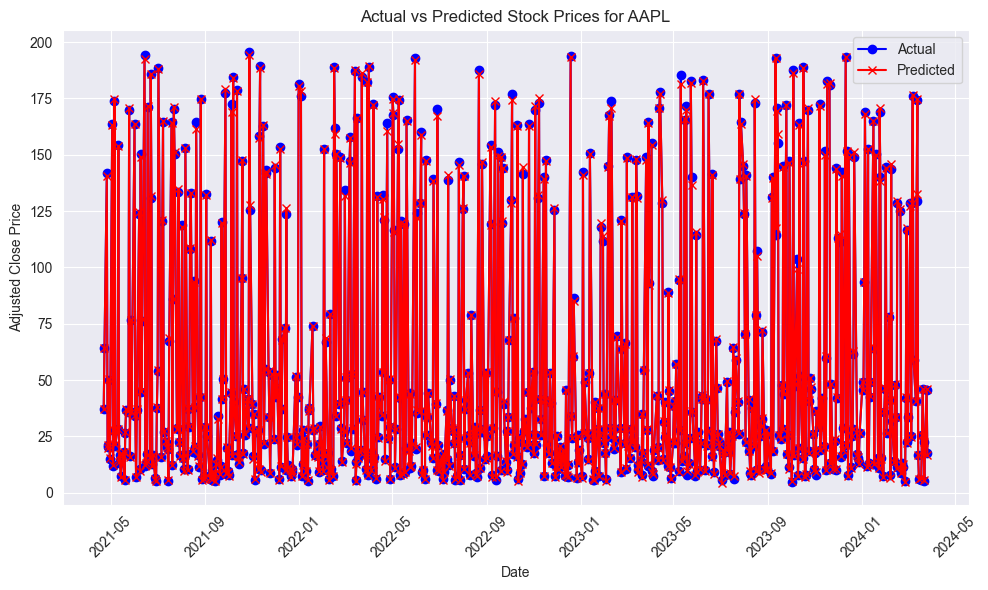

In [667]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'].iloc[len(y_train):], y_test, label='Actual', marker='o', color='blue')
plt.plot(stock_data['date'].iloc[len(y_train):], y_pred, label='Predicted', marker='x', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'Actual vs Predicted Stock Prices for {stock_symbol.upper()}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [668]:
y_pred

array([ 36.98809094,  64.45963197, 140.78461086,  21.17107711,
        19.65166727,  50.35531793,  15.25803554, 163.0456426 ,
        12.29468293,  27.65500965, 174.95769425,  21.50498669,
        28.3913134 , 153.98831541,  13.54365264,  17.18235595,
         7.21879407,  16.62103577,  17.93102373,   5.58269498,
        27.19271207,  37.2853052 ,  36.20901411, 170.89083329,
        16.051129  ,  76.76642512,  35.83951069, 163.44594563,
        34.37487042,   6.98506279,  37.02464113, 124.52829502,
         9.64158712, 149.0622677 ,  45.12553485,  77.04941773,
       192.62826356,  12.50026212,  13.16249913,  16.9342523 ,
       171.50924565,  15.92851133, 185.87506931, 131.66216778,
        11.96920344,  16.82728137,   5.97112241,   5.3588099 ,
        37.86542437,  54.32375418, 188.11823507,  16.05355167,
       121.2400189 , 164.95545705,  27.2164182 ,  23.02611076,
        20.13697374,  19.23410156,   5.46927787,  68.70947772,
       164.30255611,  12.1409752 ,  85.86327855, 170.97

In [669]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')

Test RMSE: 0.809588911704022


In [670]:
print(y_pred)

[ 36.98809094  64.45963197 140.78461086  21.17107711  19.65166727
  50.35531793  15.25803554 163.0456426   12.29468293  27.65500965
 174.95769425  21.50498669  28.3913134  153.98831541  13.54365264
  17.18235595   7.21879407  16.62103577  17.93102373   5.58269498
  27.19271207  37.2853052   36.20901411 170.89083329  16.051129
  76.76642512  35.83951069 163.44594563  34.37487042   6.98506279
  37.02464113 124.52829502   9.64158712 149.0622677   45.12553485
  77.04941773 192.62826356  12.50026212  13.16249913  16.9342523
 171.50924565  15.92851133 185.87506931 131.66216778  11.96920344
  16.82728137   5.97112241   5.3588099   37.86542437  54.32375418
 188.11823507  16.05355167 121.2400189  164.95545705  27.2164182
  23.02611076  20.13697374  19.23410156   5.46927787  68.70947772
 164.30255611  12.1409752   85.86327855 170.97860711 151.1237028
  28.41001458  28.35806447 134.72595752  22.44558066  16.26697918
 118.01811501  15.61406839   9.78856925  16.64660644 152.84968751
  10.31797707  

In [648]:
# Step 1 is correctly set up
last_row = stock_data.iloc[-1]
features_for_prediction = last_row[['RSI', 'price_ratio_to_index', 'price_ratio_to_vxx', 'price_diff_from_index', 'price_diff_from_vxx', 'log_returns', 'volatility_adjusted_returns', 'lag_1_day', 'lag_5_days', 'lag_30_days', 'lag_45_days']].values.reshape(1, -1)

predictions = []

last_date = pd.to_datetime(stock_data['date'].max())  # Ensure last_date is a datetime object
future_dates = pd.date_range(last_date, periods=10, freq='B')

for _ in range(10):
    # Predict the next day's price
    next_day_prediction = model.predict(features_for_prediction)[0]
    predictions.append(next_day_prediction)
    
    # For simplification, we'll manually shift the lag features and assume the rest remain constant
    # This approach may need adjustment based on how the non-lag features are supposed to evolve over time
    features_for_prediction[0][7] = next_day_prediction  # Update lag_1_day with the new prediction
    features_for_prediction[0][8] = features_for_prediction[0][7]  # Shift previous lag_1_day to lag_5_days
    features_for_prediction[0][9] = features_for_prediction[0][8]  # Shift previous lag_5_days to lag_30_days
    features_for_prediction[0][10] = features_for_prediction[0][9]  # Shift previous lag_30_days to lag_60_days
    # NOTE: The above logic is simplistic and assumes direct shifting which may not accurately represent your feature dynamics

# Assuming `model.predict()` expects 2D input and returns a 1D array of predictions
predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Adj Close': predictions})

print(predictions_df)


        Date  Predicted Adj Close
0 2024-03-26           177.413393
1 2024-03-27           175.687696
2 2024-03-28           173.989493
3 2024-03-29           172.318346
4 2024-04-01           170.673824
5 2024-04-02           169.055502
6 2024-04-03           167.462964
7 2024-04-04           165.895798
8 2024-04-05           164.353600
9 2024-04-08           162.835972


/Users/jocksolo/PycharmProjects/trading_advisor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jocksolo/PycharmProjects/trading_advisor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jocksolo/PycharmProjects/trading_advisor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jocksolo/PycharmProjects/trading_advisor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jocksolo/PycharmProjects/trading_advisor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X d

In [671]:
predictions_df

,Date,Predicted Adj Close
0,2024-03-26,177.413393
1,2024-03-27,175.687696
2,2024-03-28,173.989493
3,2024-03-29,172.318346
4,2024-04-01,170.673824
5,2024-04-02,169.055502
6,2024-04-03,167.462964
7,2024-04-04,165.895798
8,2024-04-05,164.353600
9,2024-04-08,162.835972


In [599]:
stock_prediction_model = 'my_stock_predictor.joblib'

# Save the model
dump(model, stock_prediction_model)

print(f"Model saved to {stock_prediction_model}")

Model saved to my_stock_predictor.joblib
